In [1]:
import os
import datetime
from datetime import datetime
from datetime import timedelta
import numpy as np
import matplotlib
import operator
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cbook as cbook
import netCDF4
import xarray as xr
import pandas as pd
import glob
from typing import List
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
warnings.simplefilter('ignore')
from pathlib import Path
import seaborn as sns
from numpy.ma import log10
import itertools
from matplotlib.pyplot import subplots, colorbar, cm
import matplotlib.colors as mcolors
from numpy.ma import log10
from matplotlib.dates import date2num, DateFormatter, HourLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [8]:
# This is the folder where the original data is stored
#original_data_path = Path("/data/archive/nsa/nsathermocldphaseC1.c1/")
original_data_path = Path("/data/archive/anx/anxthermocldphaseM1.c1/")


In [3]:
phase_map = {
    0: "clear",
    1: "liquid",
    2: "ice",
    3: "mixed",
    4: "drizzle",
    5: "liq_driz",
    6: "rain",
    7: "snow",
    8: "unknown",
}

In [4]:
# This function loads in a single file of ARM data

def getCLOUDVAP(file): # "YYYYMMDD"

    # Get Day
    if Path(file).exists():
        print("File exists.")
    else:
        print("File does not exist.")

    # Get Data
    with xr.open_dataset(file) as ds:
        ds
    time = ds['time'].data
    height = ds['height'].data
    cldphase_mplgr = ds['cloud_phase_mplgr'].data
    cldphase_layer_mplgr = ds['cloud_phase_layer_mplgr'].data
    mpl_dep = ds['mpl_linear_depol_ratio'].data
    mpl_backscat = ds['mpl_backscatter'].data * \
        (ds['height'].data**2)
    mpl_backscat[mpl_backscat <= 0] = 10**-9
    ds['mpl_backscatter'].data = mpl_backscat
    ds['mpl_backscatter'].attrs[
        'units'] = f"log10({ds['mpl_backscatter'].attrs['units']})"

    arscl_cloud_top = ds['cloud_layer_top_height'].data
    arscl_cloud_base = ds['cloud_layer_base_height'].data
    arscl_ze = ds['reflectivity_best_estimate'].data
    arscl_ze_snr = ds['radar_signal_to_noise_ratio'].data
    arscl_w = ds['spectral_width'].data
    arscl_mdv = ds['mean_doppler_velocity'].data
    combined_ze = arscl_ze.copy()
    combined_mdv = arscl_mdv.copy()
    combined_w = arscl_w.copy()
    mwr_lwp = ds['mwrret1liljclou_be_lwp'].data
    sonde_temp = ds['temp'].data

    mpl_backscat_ts = log10(mpl_backscat).transpose()

    cldphase_layer_pixel = np.zeros(mpl_backscat.shape, dtype=int)
    for j, k in itertools.product(range(0, len(time)), range(0, 10)):
        cloud_top_jk = arscl_cloud_top[j, k] * 0.001
        cloud_base_jk = arscl_cloud_base[j, k] * 0.001
        if(cloud_top_jk > 0) and (cloud_base_jk > 0):
            if(cldphase_layer_mplgr[j, k] == 1):
                cldphase_layer_pixel[j, np.where(
                    (height <= cloud_top_jk) & (height >= cloud_base_jk))] = 1
            if(cldphase_layer_mplgr[j, k] == 2):
                cldphase_layer_pixel[j, np.where(
                    (height <= cloud_top_jk) & (height >= cloud_base_jk))] = 2
            if(cldphase_layer_mplgr[j, k] == 3):
                cldphase_layer_pixel[j, np.where(
                    (height <= cloud_top_jk) & (height >= cloud_base_jk))] = 3

    return {"time": time, "height": height, "cldphase_mplgr": cldphase_mplgr,"cldphase_layer_mplgr": cldphase_layer_mplgr, "mpl_dep": mpl_dep, "mpl_backscat": mpl_backscat,"arscl_cloud_top": arscl_cloud_top, "arscl_cloud_base": arscl_cloud_base, "arscl_ze": arscl_ze, "arscl_ze_snr": arscl_ze_snr, "arscl_w": arscl_w, "arscl_mdv": arscl_mdv,"combined_ze": combined_ze, "combined_mdv": combined_mdv, "combined_w": combined_w,"mwr_lwp": mwr_lwp, "sonde_temp": sonde_temp, "mpl_backscat_ts": mpl_backscat_ts,"cldphase_layer_pixel": cldphase_layer_pixel}
# How to use:
# d = getCLOUDVAP('YYYYMMDD', date_str_list, filelist)
# time = d["time"]

In [5]:
# This function makes plots pretty :)

def set_axes(ax, pplot, font_size, font_weight, up_hgt, x_nvis,color_bar_label, padding):
    ax.set_xlabel(ax.get_xlabel(), fontsize=font_size, fontweight=font_weight)
    ax.set_ylabel(ax.get_ylabel(), fontsize=font_size, fontweight=font_weight)
    ax.set_title(ax.get_title(), fontsize=font_size, fontweight=font_weight)
    
    for tick in ax.get_xticklabels():
        tick.set_fontsize(font_size)
    
    for tick in ax.get_yticklabels():
        tick.set_fontsize(font_size)
        
    clrs = sns.color_palette("colorblind", 9)
    font = {'weight': font_weight, 'size': font_size}
    matplotlib.rc('font', **font)
    
    ax.set_ylim(0, up_hgt)
    plt.locator_params(axis='y', nbins=5)
    ax.set_ylabel('Height (km)')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", "3%", pad=padding)
    cb = colorbar(pplot, cax=cax)
    cb.ax.set_ylabel((color_bar_label))
    cb.ax.set_ylabel(cb.ax.get_ylabel(), fontsize=font_size, fontweight=font_weight)
    
    if x_nvis ==1:
        plt.setp(ax.get_xticklabels(), visible=False)
        
    return cb, ax
# # Example usage:
# fig, ax = plt.subplots()
# ax.plot([1, 2, 3, 4], [2, 4, 1, 3])

# # Call the function to set the font size for the axes
# set_axes(ax, 12, 'bold', 8, 1)

# plt.show()

In [17]:
def plot_daylies(d,figure_path):

    # colorbars
    color_map = cm.get_cmap("viridis")

    _cblind = sns.color_palette("colorblind")

    custom_colors = [
          "white",  # clear (white)
        _cblind[2],  # liquid (dark purple from viridis)
        _cblind[0],  # ice (blue from viridis)
        _cblind[3],  # mixed (greenish-blue from viridis)
        _cblind[9],  # drizzle (light green from viridis)
        _cblind[6],  # liq_driz (yellow from viridis)
        _cblind[8],  # rain (brighter yellow)
        _cblind[5],  # snow (orange-yellow)
        "black"
    ]
    cmap = mcolors.ListedColormap(custom_colors)

    # get date
    dt = d['time'][0].astype('M8[s]').astype(datetime)
    date_str = dt.strftime('%Y-%m-%d')  # '2018-06-11'

    # Create one figure with 6 subplots vertically stacked
    fig, axes = plt.subplots(nrows=7, figsize=(14, 13), sharex=True)

    # Add title
    #fig.suptitle(f"Observations for {date_str}", fontsize=14)

    # Unpack axes
    ax0, ax1, ax2, ax3, ax4, ax5, ax6 = axes

    y_height = 7.5
    # set temp font size
    tfz = 10
    # Subplot 1: mpl backscatter
    p0 = ax0.pcolormesh(d['time'], d['height'], d['mpl_backscat_ts'], vmin=-3, vmax=2, cmap=color_map, shading='auto')#vmin=-3, vmax=2
    contour = ax0.contour(d['time'], d['height'], d['sonde_temp'].transpose(), vmin=-40, vmax=40,
                    levels=9, colors='black', linestyles='--', linewidths=0.5)
    ax0.clabel(contour, fontsize=tfz, inline=True, fmt='%1.0f°C')
    set_axes(ax0, p0, 12, 'bold', y_height, 1, r'MPL $\beta$', "4%")
    ax0.set_ylim(0, y_height);ax0.set_yticks([0, 2, 4, 6,8])

    # Subplot 2: mpl_linear_depol_ratio
    p1 = ax1.pcolormesh(d['time'], d['height'], d['mpl_dep'].transpose(), vmin=0, vmax=0.6, cmap=color_map, shading='auto')
    contour = ax1.contour(d['time'], d['height'], d['sonde_temp'].transpose(), vmin=-40, vmax=40,
                        levels=9, colors='black', linestyles='--', linewidths=0.5)
    ax1.clabel(contour, fontsize=tfz, inline=True, fmt='%1.0f°C')
    set_axes(ax1, p1, 12, 'bold', y_height, 1, r'MPL Dep', "4%")
    ax1.set_ylim(0, y_height);ax1.set_yticks([0, 2, 4, 6,8])
    
    # Subplot 3: radar Ze
    p2 = ax2.pcolormesh(d['time'], d['height'], d['combined_ze'].transpose(), vmin=-40, vmax=20, cmap=color_map, shading='auto')
    contour = ax2.contour(d['time'], d['height'], d['sonde_temp'].transpose(), vmin=-40, vmax=40,
                        levels=9, colors='black', linestyles='--', linewidths=0.5)
    ax2.clabel(contour, fontsize=tfz, inline=True, fmt='%1.0f°C')
    set_axes(ax2, p2, 12, 'bold', y_height, 1, 'Ze (dBZ)', "4%")
    ax2.set_ylim(0, y_height);ax2.set_yticks([0, 2, 4, 6,8])

    # Subplot 4: radar Doppler velocity
    p3 = ax3.pcolormesh(d['time'], d['height'], d['combined_mdv'].transpose(), vmin=-1, vmax=1, cmap=color_map, shading='auto')
    contour = ax3.contour(d['time'], d['height'], d['sonde_temp'].transpose(), vmin=-40, vmax=40,
                        levels=9, colors='black', linestyles='--', linewidths=0.5)
    ax3.clabel(contour, fontsize=tfz, inline=True, fmt='%1.0f°C')
    set_axes(ax3, p3, 12, 'bold', y_height, 1, 'MDV (m/s)', "4%")
    ax3.set_ylim(0, y_height);ax3.set_yticks([0, 2, 4, 6,8])

    # Subplot 5: radar Doppler spectral width
    p4 = ax4.pcolormesh(d['time'], d['height'], d['combined_w'].transpose(), vmin=0, vmax=0.5, cmap=color_map, shading='auto')
    contour = ax4.contour(d['time'], d['height'], d['sonde_temp'].transpose(), vmin=-40, vmax=40,
                        levels=9, colors='black', linestyles='--', linewidths=0.5)
    ax4.clabel(contour, fontsize=tfz, inline=True, fmt='%1.0f°C')
    set_axes(ax4, p4, 12, 'bold', y_height, 1, 'W (m/s)', "4%")
    ax4.set_ylim(0, y_height);ax4.set_yticks([0, 2, 4, 6,8])
    
    # Subplot 6, LWP
    p5 = ax5.plot(d['time'], d['mwr_lwp'], color = 'black')
    ax5.set_ylabel('LWP (g/m$^2$)', fontweight = 'bold')
    ax5.set_ylim([0,1600])
    #set_axes(ax5, p5, 12, 'bold', 8, 1, '', "4%")
    divider = make_axes_locatable(ax5)
    cax = divider.append_axes("right", "3%", pad="4%")
    plt.setp(ax5.get_xticklabels(), visible=False)
    ax5.set_ylim(0, 1000);ax5.set_yticks([0, 250, 500, 750, 1000])
    
    # Subplot 7: cloud phase + contours
    #cmap = ListedColormap(['w', 'g', 'b', 'r', 'gray', 'm', 'y', 'brown', 'c'])
    contour = ax6.contour(d['time'], d['height'], d['sonde_temp'].transpose(), vmin=-40, vmax=40,
                        levels=9, colors='black', linestyles='--', linewidths=0.5)
    ax6.clabel(contour, fontsize=tfz, inline=True, fmt='%1.0f°C')

    p6 = ax6.pcolormesh(d['time'], d['height'], d['cldphase_mplgr'].transpose(), vmin=0, vmax=9, cmap=cmap, shading='auto')

    cb, _ = set_axes(ax6, p6, 12, 'bold', 7, 0, '', "4%")
    cb.ax.locator_params(nbins=9)
    cb.set_ticks([0, 1, 2, 3, 4, 5, 6, 7])
    cb.set_ticklabels(['Clear', 'Liquid', 'Ice', 'Mixed', 'Drizzle', 'Liq_Driz', 'Rain', 'Snow'])
    for label in cb.ax.get_yticklabels():
        label.set_fontsize(10)
        label.set_fontweight('normal') 


    # Set shared x-axis formatter
    date_fmt = DateFormatter('%H:00')
    hour_loc = HourLocator(interval=5)
    ax6.xaxis.set_major_formatter(date_fmt)
    ax6.xaxis.set_major_locator(hour_loc)

    # Add identifiers
    # Define letters to be added to each subplot
    letters = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']

    for i, ax in enumerate(axes):
        if i < 13: 
            ax.text(
                x=0.02,  # Position near the left side of the subplot
                y=0.96,   # Position near the top of the subplot
                s=letters[i],  # Corresponding letter for each subplot
                transform=ax.transAxes,  # Coordinates are in axes-relative units
                verticalalignment="top",
                horizontalalignment="left",
                fontweight="bold",
                fontsize=12,
                bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1'))

    #plt.tight_layout()

    fig.savefig(figure_path / f"Figure_1_revised_{date_str}.png", dpi=300, bbox_inches='tight')
    plt.show()
    return

In [9]:
# Set Date
#datestring = '20210815'
datestring = '20200225'

# Load our ARM data
file = glob.glob(os.path.join(original_data_path, '*' + datestring + '*.nc'))[0]
d = getCLOUDVAP(file) # Arm data opened as a dictionary


File exists.


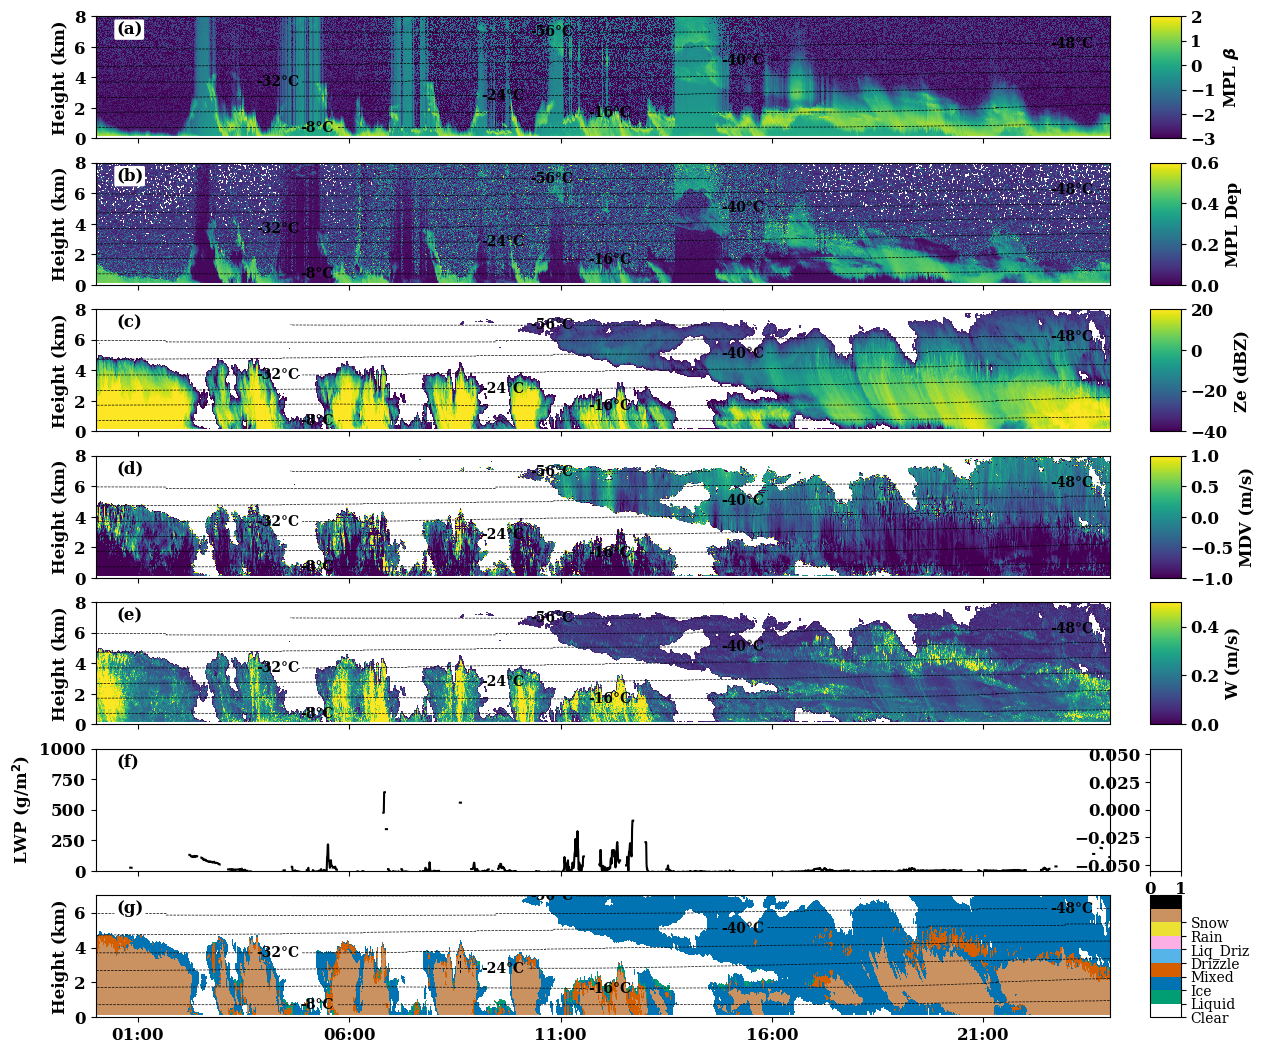

In [18]:
# Figure automatically saved to figures folder
plt.rcParams['font.family'] = 'serif'
plot_daylies(d,Path("/home/goldberger/ML_Plotting"))

In [ ]:
pwd
